## HIGH DIMENSIONAL ANALYSIS


*   **Programing Exercise: 03**
*   **Name: Đinh Anh Huy**
*   **Student code       : 18110103**




In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
%matplotlib inline

**Thuật toán K-Means Clustering**

Thuật toán K-Means Clustering được thực hiện theo các bước sau:

1. Chọn **K** điểm bất kỳ trong tập huấn luyện làm các tâm cụm ban đầu.
2. Phân mỗi điểm dữ liệu vào cụm có tâm gần nhất.
3. Cập nhật lại tâm cụm bằng cách lấy trung bình cộng củacác điểm đã được gán vào cụm đó sau bước 2.
4. Nếu tâm cụm mới được hình thành không thay đổi so với vòng lặp trước thì dừng lại.
5. Quay lại bước 2.

Trong đó, việc lấy ngẫu nhiên **K** điểm trong tập huấn luyện làm tâm cụm ban đầu có thể dẫn đến trường hợp các tập cụm ban đầu ở khá gần nhau, do đó kết quả đầu ra của thuật toán K-Means Clustering có thể không được như mong muốn (không tốt). Vì vậy, ta thay thế bước 1 thành phương pháp K-Means++ có các bước như sau:

1.  Khởi tạo một tập rỗng M để lưu trữ K tâm cụm.
2. Chọn ngẫu nhiên tâm cụm đầu tiền μ 1 từ các mẫu đầu vào và thêm nó vào M.
3. Đối với mỗi điễm dữ liệu x i không có trong M, tìm bình phương khoảng cách d(x i , M ) 2 đến bất kỳ tâm nào trong M.
4. Chọn ngẫu nhiên tâm cụm tiếp theo μ p bằng cách sử dụng phân phối xác suất có trọng số bằng $\frac{d(\mu, M)^2}{\sum_id(x_i, M)^2}$
5. Lặp lại bước 2 và 3 đến khi tìm đủ K tâm cụm.
6. Bây giờ các tâm cụm ban đầu đã được chọn, ta tiếp tục thực hiện các bước tiếp theo tương tựthuật toán K-Means cổ điển.

Từ ý tưởng trên, ta xây dựng `class K_Means` có:

* *Tham số:*

  * `n_clusters`: Số cụm khởi tạo.
  * `random_state`: random state cố định cho việc lấy ngẫu tâm cụm khởi tạo.

* *Thuộc tính*:
  
  * `n_clusters`: Số cụm cần gom nhóm.
  * `rnd`: random state.
  * `list_centroids`: Danh sách lưu các tâm cụm sau mỗi lần cập nhật.
  * `list_labels`: Danh sách lưu label của từng sample sau mỗi lần cập nhật tâm cụm.
  * `inertia_`: tổng bình phương khoảng cách của các sample đến tâm cụm gần nhất.
  * `cluster_centers_`: Các tâm cụm cuối cùng sau khi thực hiện thuật toán.
  * `labels_`: Nhãn của các sample trong tập dữ liệu.
  * `n_iter_`: Số lần cập nhật tâm cụm.

* *Phương thức*:

  * `_calc_wcv(X, centroids)`: Tính tổng bình phương khoảng cách của các sample trong `X` đến các tâm cụm trong `centroids`.
  * `_calc_distribution(X, centroids)`: Tính phân bố để tạo ra các tâm cụm mới.
  * `_get_centroid(X, distribution)`: Chọn tâm cụm mới dựa trên trọng số của phân phối.
  * `_init_centroids(X)`: Khởi tạo các điểm centroid ban đầu.
  * `_assign_label(X, centroids)`: Gán nhãn mới cho các điểm dữ liệu ứng với centroid gần nhất.
  * `_has_converged(old_centroids, new_centroids)`: Kiểm tra tính hội tụ và điều kiện dừng của bài toán.
  * `_update_centroids(X, labels)`: Cập nhật lại tâm cụm khi biết nhãn của từng điểm.
  * `fit(X)`: Áp dụng thuật toán K-Means Clustering cho tập huấn luyện `X`.
  * `predict(X)`: Dự đoán label cho từng điểm trong tập test `X` sau khi train.

In [ ]:
class K_Means:
  def __init__(self, n_clusters=3, random_state=0):
    self.n_clusters = n_clusters
    self.rnd = np.random.RandomState(random_state)
    self.list_centroids = []
    self.list_labels = []
    self.inertia_ = None
    self.cluster_centers_ = None
    self.labels_ = None
    self.n_iter_ = None

  def _calc_wcv(self, X, centroids):
    differences = cdist(X, centroids)
    return np.sum(np.min(differences, axis=1)**2)

  def _calc_distribution(self, X, centroids):
    differences = cdist(X, centroids)
    wcv = self._calc_wcv(X, centroids)
    return np.min(differences**2, axis=1)/wcv

  def _get_centroid(self, X, distribution):
    return X[self.rnd.choice(range(len(distribution)), 1, p=distribution), :]
  
  def _init_centroids(self, X):
    centroids = X[self.rnd.choice(X.shape[0],1),:]
    while centroids.shape[0] < self.n_clusters :  
      p = self._calc_distribution(X, centroids)
      centroids = np.r_[centroids, self._get_centroid(X, p)]
    self.list_centroids.append(centroids)

  def _assign_label(self, X, centroids):
    differences = cdist(X, centroids)
    return np.argmin(differences, axis=1)

  def _has_converged(self, old_centroids, new_centroids):
    return (set([tuple(c) for c in old_centroids]) == set([tuple(c_new) for c_new in new_centroids]))

  def _update_centroids(self, X, labels):
    centroids = np.zeros((self.n_clusters, X.shape[1]))
    for k in range(self.n_clusters):
      Xk = X[labels == k, :]
      centroids[k,:] = np.mean(Xk, axis = 0)
    return centroids    

  def fit(self, X):
    if type(X) is not np.ndarray:
      X = X.toarray()

    self._init_centroids(X)
    iter = 0
    while True:
      self.list_labels.append(self._assign_label(X, self.list_centroids[-1]))
      new_centroids = self._update_centroids(X, self.list_labels[-1])
      if self._has_converged(self.list_centroids[-1], new_centroids):
        break
      self.list_centroids.append(new_centroids)
      iter += 1
    self.inertia_ = self._calc_wcv(X, self.list_centroids[-1])
    self.n_iter_ = iter
    self.labels_ = self.list_labels[-1]
  
  def predict(self, X):
    return self._assign_label(X, self.list_centroids[-1])

**Import the CSV file *'College.csv'* and do the following analytics:**

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/High-Dimentional Analysis/Lab03 - KMeans/College.csv"
data = pd.read_csv(path)
data.rename(columns={data.columns[0]:'Name'}, inplace=True)
print("Shape of data: ", data.shape)
data.head()

Shape of data:  (777, 19)


,Name,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         777 non-null    object 
 1   Private      777 non-null    object 
 2   Apps         777 non-null    int64  
 3   Accept       777 non-null    int64  
 4   Enroll       777 non-null    int64  
 5   Top10perc    777 non-null    int64  
 6   Top25perc    777 non-null    int64  
 7   F.Undergrad  777 non-null    int64  
 8   P.Undergrad  777 non-null    int64  
 9   Outstate     777 non-null    int64  
 10  Room.Board   777 non-null    int64  
 11  Books        777 non-null    int64  
 12  Personal     777 non-null    int64  
 13  PhD          777 non-null    int64  
 14  Terminal     777 non-null    int64  
 15  S.F.Ratio    777 non-null    float64
 16  perc.alumni  777 non-null    int64  
 17  Expend       777 non-null    int64  
 18  Grad.Rate    777 non-null    int64  
dtypes: float

**(a) Find all private school with a graduation rate of higher than 90%.**

In [ ]:
selected_data = data.loc[(data['Private']=='Yes') & (data['Grad.Rate']>90)]
print("Number of private school with a graduation rate of higher than 90%: ", selected_data.shape[0])
selected_data.head()

Number of private school with a graduation rate of higher than 90%:  60


,Name,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
16,Amherst College,Yes,4302,992,418,83,96,1593,5,19760,5300,660,1598,93,98,8.4,63,21424,100
37,Barnard College,Yes,2496,1402,531,53,95,2121,69,17926,8124,600,850,83,93,10.3,33,12580,91
60,Bowdoin College,Yes,3356,1019,418,76,100,1490,8,19030,5885,1495,875,93,96,11.2,52,20447,96
70,Brown University,Yes,12586,3239,1462,87,95,5643,349,19528,5926,720,1100,99,100,7.6,39,20440,97
72,Bucknell University,Yes,6548,3813,862,49,85,3316,31,18550,4750,800,1200,95,97,14.2,36,13675,93


**(b) Using all attributes from the initial dataet except for the Private attribute, do the K-mean clustering method with two clusters. After this step, we will split the original data into two groups (private or not).**

**(c) Illustrate the predicted cluster and Private attribute (ground truth) to compare them. Please write your comment about the results.**

In [ ]:
X = data.drop(['Name', 'Private'], axis=1).values
y = data['Private'].values

In [ ]:
model = K_Means(n_clusters=2, random_state=42)
model.fit(X)
print('>> Total Within Sum of Square: ', model.inertia_)
label_pred = model.predict(X)
unique_values, count_values = np.unique(label_pred, return_counts=True)
print('>> Number of samples on each cluster:')
for i in range(len(unique_values)):
  print('   - Cluster {}: {}'.format(unique_values[i], count_values[i]))
print('>> Predicted labels: \n', label_pred)

>> Total Within Sum of Square:  48356202264.49213
>> Number of samples on each cluster:
   - Cluster 0: 669
   - Cluster 1: 108
>> Predicted labels: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 1

In [ ]:
ground_truth = np.where(y == 'Yes', 0, 1)
acc_score = accuracy_score(ground_truth, label_pred)
print(">> The accuracy for predicted clusters and the ground truth: ", acc_score)

unique_values, count_values = np.unique(ground_truth, return_counts=True)
print('>> Number of samples on each true cluster :')
for i in range(len(unique_values)):
  print('   - Cluster {}: {}'.format(unique_values[i], count_values[i]))

print(">> The ground truth: \n", ground_truth)

>> The accuracy for predicted clusters and the ground truth:  0.7786357786357786
>> Number of samples on each true cluster :
   - Cluster 0: 565
   - Cluster 1: 212
>> The ground truth: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1
 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

**Dimensionality reduction to 2 dimensions and visualize the predicted labels**

In [ ]:
# Implement PCA with scikit-learn library
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X)

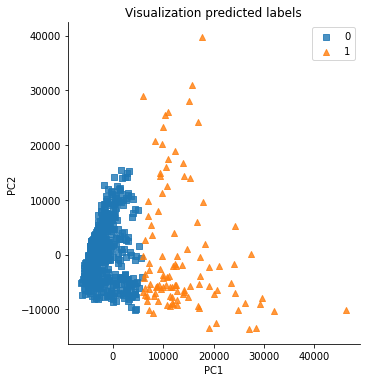

In [ ]:
# Plot transformed features in PCA subspace
df = pd.DataFrame(data_pca)
df['class'] = label_pred
df.columns = ["PC1", "PC2", "class"]

markers = ['s', '^']
sns.lmplot(x="PC1", y="PC2", data=df, markers=markers, fit_reg=False, hue='class', legend=False)
plt.legend(loc='upper right')
plt.title("Visualization predicted labels")
plt.show()

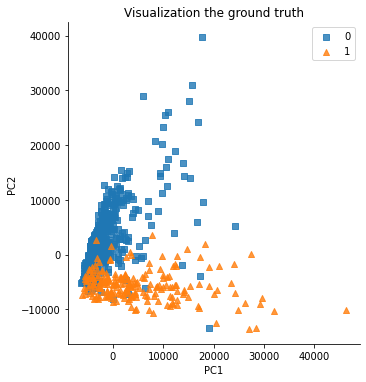

In [ ]:
# Plot transformed features in PCA subspace
df_gt = pd.DataFrame(data_pca)
df_gt['class'] = ground_truth
df_gt.columns = ["PC1", "PC2", "class"]

markers = ['s', '^']
sns.lmplot(x="PC1", y="PC2", data=df_gt, markers=markers, fit_reg=False, hue='class', legend=False)
plt.legend(loc='upper right')
plt.title("Visualization the ground truth")
plt.show()

**Implement K-Means Clustering with scikit-learn library**

In [ ]:
model_skl = KMeans(n_clusters=2, random_state=42)
model_skl.fit(X)
label_pred_skl = model_skl.predict(X)
print('>> Total Within Sum of Square: ', model_skl.inertia_)

unique_values, count_values = np.unique(label_pred_skl, return_counts=True)
print('>> Number of samples on each cluster:')
for i in range(len(unique_values)):
  print('   - Cluster {}: {}'.format(unique_values[i], count_values[i]))

acc_score = accuracy_score(ground_truth, label_pred_skl)
print(">> The accuracy for K-Means Clustering algorithm using scikit-learn library: ", acc_score)

print('>> Predicted labels: \n', label_pred_skl)

>> Total Within Sum of Square:  48356202264.492134
>> Number of samples on each cluster:
   - Cluster 0: 669
   - Cluster 1: 108
>> The accuracy for K-Means Clustering algorithm using scikit-learn library:  0.7786357786357786
>> Predicted labels: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 

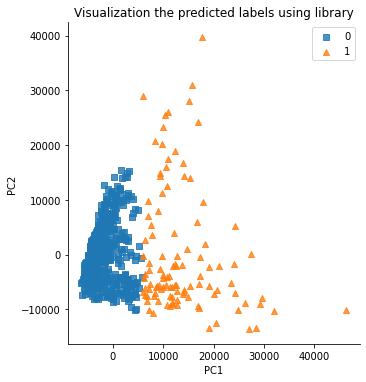

In [ ]:
# Plot transformed features in PCA subspace
df_skl = pd.DataFrame(data_pca)
df_skl['class'] = label_pred_skl
df_skl.columns = ["PC1", "PC2", "class"]

markers = ['s', '^']
sns.lmplot(x="PC1", y="PC2", data=df_skl, markers=markers, fit_reg=False, hue='class', legend=False)
plt.legend(loc='upper right')
plt.title("Visualization the predicted labels using library")
plt.show()

**Comment:**

* So sánh với kết quả thu được từ việc chạy hàm tự build với hàm của thư viện scikit-learn, ta thấy rằng cả 2 đều cho ra cùng một kết quả với:
  * Total Within Sum of Square: 48356202264.492134
  * Accuracy khi so sánh predicted labels với ground truth: 0.7786357786357786

* So sánh với ground truth, thuật toán K-Means gom dữ liệu ban đầu với tất cả attribute trừ *Private* attribute thành 2 nhóm cho ra kết quả chỉ đúng khoảng 78% so với ground truth ban đầu. Tuy nhiên, con số này cũng tương đối cao và có thể chấp nhận được. Do về bản chất, thuật toán K-Means Clustering phục vụ cho các bài toán Unsupervised (dữ liệu không biết trước label) nên kết quả gom nhóm chỉ mang tính chất tương đối so với thực tế.

* So sánh với scatter plot, ta thấy rằng dữ liệu được phân nhóm bằng thuật toán K-Means Clustering cho ra kết quả khác so với ground truth, cụ thể là khác khoảng 22%. Điều đó cho thấy được thuật toán K-Means Clustering chỉ thực hiện gom nhóm dữ liệu theo tính chất của các attributes được cung cấp, do đó kết quả đưa ra chỉ mang tính chất tương đối.